## Introduction
Semantic textual similarity deals with determining how similar a pair of text documents are. The goal of the first task is to implement a new architecture by combining the ideas from papers
- Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al (will be referred as the AAAI paper)
- A Structured Self-Attentive Sentence Embedding, Zhouhan Lin et. al (will be referred as the ICLR paper) <br/><br/>
Furthermore, you'd be evaluating whether the new architecture improves the results of **Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al**. Your overall network architecture should look similar to the following figure. 
![Untitled%20Diagram.drawio%20%281%29.png](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/download.png)
<br/><br/>


Moreover, you'd be required to implement further helper functions that these papers propose i.e., attention penalty term for loss, etc.
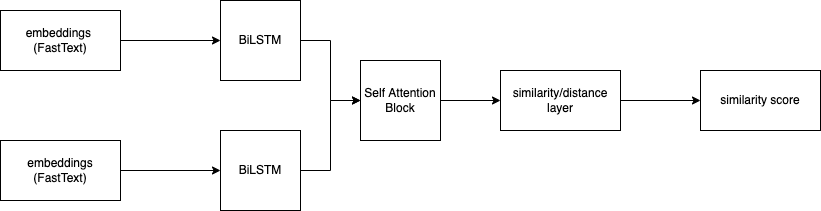

### SICK dataset
We will use SICK dataset throughout the project (at least in the first two tasks). To get more information about the dataset you can refer to the original [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/363_Paper.pdf) on the dataset. You can download the dataset using one of the following links:
- [dataset page 1](https://marcobaroni.org/composes/sick.html)
- [dataset page 2](https://huggingface.co/datasets/sick)    

The relevant columns for the project are `sentence_A`, `sentence_B`, `relatedness_score`, where `relatedness_score` is the label. <br><br>
**Hint: For each task make sure to decide whether the label should be normalized or not.**<br><br>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload

## Part 1. Data pipeline (3 points)
Before starting working on the model, we must configure the data pipeline to load the data in the correct format. Please, implement the functions for processing the data.

### Part 1.1 Loading and preprocessing the data (1 point)
Download the SICK dataset and store it in [pandas](https://pandas.pydata.org/docs/index.html) `Dataframe`'s. You should use the official data split.  

Implement `load_data` method of `STSData` class in `sts_data.py`. The method must download the dataset and perform basic preprocessing. Minimal preprocessing required:  
1. normalize text to lower case
2. remove punctuations  
3. remove [stopwords](https://en.wikipedia.org/wiki/Stop_word) - we provided you with the list of English stopwords.
4. Optionally, any other preprocessing that you deem necessary.

All the preprocessing code must be contained in the `preprocessing.py` file.  
You can use Hugginface's [datasets library](https://huggingface.co/docs/datasets/) for easy dataset download.

### Part 1.2 Building vocabulary (1 point)
Before we can feed our text to the model it must be vectorized. We use 300 dimensional pretrained [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) for mapping words to vectors. To know more general information about embeddings you can refer to [this video](https://www.youtube.com/watch?v=ERibwqs9p38) (even though, we use different types of embeddings - FastText vs Word2Vec described in the video - the general purpose of them is the same).  
In order to apply the embedding, we must first construct the vocabulary for data. Complete the `create_vocab` method of `STSData` class in `sts_data.py` where you concatenate each sentence pair, tokenize it and construct the vocabulary for the whole training data. You should use [torchtext](https://torchtext.readthedocs.io/en/latest/data.html
) for processing the data. For tokenization, you can use any library (or write your own tokenizer), but we recommend you to use tokenizer by [spacy](https://spacy.io/). Use the `fasttext.simple.300d` as pretrained vectors.  
In the end, you must have a vocabulary object capable of mapping your input to corresponding vectors. Remember that the vocabulary is created using only training data (not touching validation or test data).

### Part 1.3 Creating DataLoader (1 point)
Implement `get_data_loader` method of `STSData` class in `sts_data.py`. It must perform the following operations on each of the data splits:
1. vectorize each pair of the sentences by replacing all tokens with their index in vocabulary
2. normalize labels
3. convert everything to PyTorch tensors
4. pad every sentence so that all of them have the same length
5. create `STSDataset` from `dataset.py`
6. create PyTorch DataLoader out of the created dataset. 


We have provided you with the interfaces of possible helper functions, but you can change them as you need.   
In the end, you must have 3 data loaders for each of the splits.

In [3]:
reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 128

sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...
100%|██████████| 3/3 [00:00<00:00, 748.94it/s]
INFO:root:Four kids are doing backbends in the park
INFO:root:Four children are doing backbends in the park
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task1\preprocess.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_A'] = dataset['train']['sentence_A'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task1\preprocess.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_B'] = dataset['train']['sentence_B'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task1\preprocess.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['test']['sentence_A'] = dat

Testing vocab. Index for kids is 65
Testing vocab. Index for sentence ['kids', 'playing', 'yard', 'standing', 'background'] is [65, 4, 144, 6, 141]
<unk>
<pad>
woman
Index(['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score',
       'entailment_AB', 'entailment_BA', 'sentence_A_original',
       'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
      dtype='object')
max len a: 14, max_len b: 14, max_len 14
[228, 93, 7, 572, 368, 0, 0, 0, 0, 0, 0, 0, 0, 0]
max len a: 12, max_len b: 14, max_len 14
[5, 10, 41, 14, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0]
max len a: 14, max_len b: 14, max_len 14
[1347, 12, 16, 164, 1287, 180, 0, 0, 0, 0, 0, 0, 0, 0]


## Part 2. Model Configuration & Hyperparameter Tuning (3 points)
In this part, you are required to define a model capable of learning self-attentive sentence embeddings described in [this ICLR paper](https://arxiv.org/pdf/1703.03130.pdf). The sentence embedding learned by this model will be used for computing the similarity score instead of the simpler embeddings described in the original AAAI paper.  
Please familiarize yourself with the model described in the ICLR paper and implement `SiameseBiLSTMAttention` and `SelfAttention` classes in `siamese_lstm_attention.py`. Remember that you must run the model on each sentence in the sentence pair to calculate the similarity between them. You can use `similarity_score` from `utils.py` to compute the similarity score between two sentences. 
  
To get more theoretical information about attention mechanisms you can refer to [this chapter](https://web.stanford.edu/~jurafsky/slp3/10.pdf) of ["Speech and Language Processing" book](https://web.stanford.edu/~jurafsky/slp3/) by Dan Jurafsky and James H. Martin, where the attention mechanism is described in the context of the machine translation task. 

Finally, once your implementation works on the default parameters stated below, make sure to perform **hyperparameter tuning** to find the best combination of hyperparameters.

In [4]:
output_size = 128
hidden_size = 403
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 0.00048586475278877557
fc_hidden_size = 89
max_epochs = 200
bidirectional = True
dropout = 0.12354567224086944
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 400,  ## refers to variable 'da' in the ICLR paper
    "output_size": 14,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.1965166853622733,  ## refers to penalty coefficient term in the ICLR paper
}

In [5]:
from siamese_lstm_attention import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
    dropout=dropout
)
## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (word_embeddings): Embedding(1962, 300)
  (biLSTM): LSTM(300, 403, num_layers=4, dropout=0.12354567224086944, bidirectional=True)
  (attention): SelfAttention(
    (Ws1): Linear(in_features=806, out_features=400, bias=False)
    (Ws2): Linear(in_features=400, out_features=14, bias=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=11284, out_features=89, bias=False)
    (1): ReLU()
    (2): Linear(in_features=89, out_features=128, bias=False)
  )
)

In [7]:
from train import train_model, train_hyperparameters, genetic_hyperparam_search

genetic_hyperparam_search(data_loader=sick_dataloaders,device=device, vocab_size=vocab_size, embedding_weights=embedding_weights, max_epochs=25, num_gens=20,
config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    })

INFO:root:Finding best hyperparameters using genetic algorithm
INFO:root:starting generation 0
INFO:root:Starting train for model with parameters hidden_size=128,lstm_layers=2,fc=128,dropout=0.4555789373404718,a_hs=400,a_os=30,p=0.23653065693753494, lr=0.001, o_size=253
100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
INFO:root:0.720948644852313
INFO:root:Starting train for model with parameters hidden_size=256,lstm_layers=4,fc=128,dropout=0.14756378098058903,a_hs=400,a_os=45,p=0.4248427445779662, lr=0.002, o_size=242
100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
INFO:root:0.7029058532854447
INFO:root:Starting train for model with parameters hidden_size=512,lstm_layers=3,fc=256,dropout=0.07807337269417375,a_hs=400,a_os=40,p=0.7713499338194637, lr=0.002, o_size=121
100%|██████████| 25/25 [00:46<00:00,  1.85s/it]
INFO:root:0.7168562715968895
INFO:root:Starting train for model with parameters hidden_size=512,lstm_layers=8,fc=64,dropout=0.06985179982653583,a_hs=400,a_os=20,p=0.25567863512

KeyError: 'val_acc'

## Part 3. Training (2 points)  
Perform the final training of the model by implementing functions in `train.py` after setting values of your best-chosen hyperparameters. Note you can use the same training function when performing hyperparameter tuning.
- **What is a good choice of performance metric here for evaluating your model?** [Max 2-3 lines]

ANS: A good choice of performance metric is either the Pearson correlation used in the AAAI paper, or Spearmans rank correlation, used in the sentence-BERT paper. The Spearmans rank correlation is slightly better as a metric, because Pearson correlation is sensitive to outliers and can only measure linear relationships. Nonetheless, we chose to use Pearson correlation for better comparison to the AAAI paper.

- **What other performance evaluation metric can we use here for this task? Motivate your answer.**[Max 2-3 lines]

ANS: One possible choice would be to measure the percentage of sentence pairs that were 'correctly' scored. However, due to the score being a continuous variable, we would then have to decide on arbitrary bins to measure correctness. Other choices include normalized Cumulative Gain, normalized Discounted Cumulative Gain and F1-score.

In [8]:
# INFO:root:Starting train for model with parameters hidden_size=65,lstm_layers=3,fc=54,dropout=0.004552032510285575,a_hs=110,a_os=45,p=0.21889161396343187, lr=0.000982054520506434, o_size=24
# INFO:root:Starting train for model with parameters hidden_size=609,lstm_layers=3,fc=148,dropout=0.16087194784393588,a_hs=133,a_os=43,p=0.345324101357837, lr=4.56425358662613e-05, o_size=247


batch_size = 64
output_size = 247
hidden_size = 609
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 3
learning_rate = 4.56425358662613e-05
fc_hidden_size = 148
max_epochs = 100
bidirectional = True
dropout = 0.16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 133,  ## refers to variable 'da' in the ICLR paper
    "output_size": 43,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.34532410135783,  ## refers to penalty coefficient term in the ICLR paper
}

In [9]:
from siamese_lstm_attention import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
    dropout=dropout
)
## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (word_embeddings): Embedding(1962, 300)
  (biLSTM): LSTM(300, 609, num_layers=3, dropout=0.16087194784393588, bidirectional=True)
  (attention): SelfAttention(
    (Ws1): Linear(in_features=1218, out_features=133, bias=False)
    (Ws2): Linear(in_features=133, out_features=43, bias=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=52374, out_features=148, bias=False)
    (1): ReLU()
    (2): Linear(in_features=148, out_features=247, bias=False)
  )
)

In [10]:
from train import train_model, train_hyperparameters

optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters(), lr=learning_rate)

best_model, train_losses, train_accs, val_losses, val_accs = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Epoch: 0
INFO:root:new model saved
INFO:root:Train loss: 0.4590456187725067 - acc: 0.38691504807196997 -- Validation loss: 0.4553401470184326 - acc: 0.5756880485914952
  1%|          | 1/100 [00:02<04:45,  2.89s/it]INFO:root:Epoch: 1
INFO:root:new model saved
INFO:root:Train loss: 0.442535936832428 - acc: 0.6465552375749191 -- Validation loss: 0.4515714943408966 - acc: 0.6365142544647366
  2%|▏         | 2/100 [00:05<04:31,  2.77s/it]INFO:root:Epoch: 2
INFO:root:new model saved
INFO:root:Train loss: 0.43953055143356323 - acc: 0.7021388847898132 -- Validation loss: 0.4505192041397095 - acc: 0.6636553903096474
  3%|▎         | 3/100 [00:08<04:24,  2.73s/it]INFO:root:Epoch: 3
INFO:root:new model saved
INFO:root:Train loss: 0.4379032850265503 - acc: 0.7277437578331589 -- Validation loss: 0.4487612247467041 - acc: 0.6690854146487644
  4%|▍         | 4/100 [00:10<04:20,  2.71s/it]INFO:root:Epoch: 4
INFO:root:new model saved
INFO:root:Train los

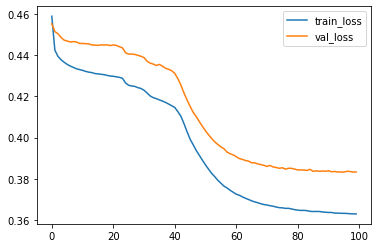

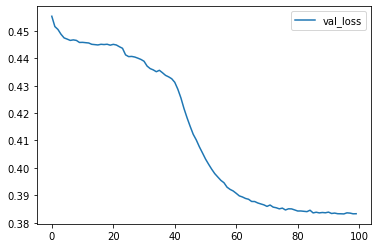

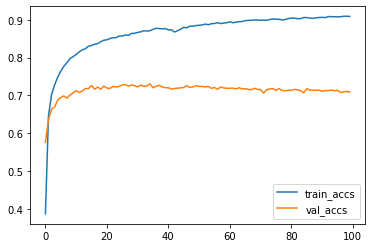

In [11]:
import matplotlib.pyplot as plt
#print(val_losses)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.savefig('train_loss_task_1.png')
plt.show()


plt.plot(val_losses, label='val_loss')
plt.legend()
plt.savefig('val_loss_task_1.png')
plt.show()

plt.plot(train_accs, label='train_accs')
plt.plot(val_accs, label='val_accs')
plt.legend()
plt.savefig('accuracies_task_1.png')
plt.show()

## Part 4. Evaluation and Analysis (2 points)  
Implement function evaluate_test_set to calculate the final accuracy of the performance evaluation metric on the test data.  
Compare the result with the original AAAI paper. Сomment on effect of penalty loss on model capacity. Did the inclusion of the self-attention block improve the results? If yes, then how? Can you think of additional techniques to improve the results? Briefly answer these questions in the markdown cells.

## ANS: 
#### Effect of penalty loss on model capacity: 
The penalty loss acts as a form of regularization, therefore decreasing model capacity. It attempts to penalize the attention vectors, so that each one tries to focuse on a different aspect of the sentence, thus reducing redudency in the attention layer.

#### Did the inclusion of the self-attention block improve the results: 
The inclusion did not improve results. Our final model achieved a Pearson correlation of r=0.74 and Spearman correlation rho=0.61, which is far below the results of the AAAI paper. Although this might be due to a mistake in the implementation, or maybe due to removing too many words during the stop word removal process. We noticed that some sentences are only made up of <pad> tokens, for example.


#### Additional techniques to improve the results: 
One way to improve results is to gather more data. With a larger dataset, the resulting model should become better, maybe using more regularization to avoid overfitting. One wy to get more data could be to make new sentence pairs by exchanging some words with synonyms. This would not change the meaning of the sentence, but create a new sentence pair withput having to manually score the similarity.

In [12]:
best_model = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
    dropout=dropout
)
## move model to device
best_model.to(device)
best_model.load_state_dict(torch.load("siamese_lstm_attention.pth"))


test_acc, r, rho, mse = evaluate_test_set(
    model=best_model,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

print('final accuracy on test set is {}'.format(test_acc))
print('pearsons r test set is {}'.format(r))
print('spearman rho on test set is {}'.format(rho))
print('mean square error on test set is {}'.format(mse))

INFO:root:Evaluating accuracy on test set


final accuracy on test set is 0.5490593252931693
pearsons r test set is (0.7411490000803717, 0.0)
spearman rho on test set is SpearmanrResult(correlation=0.6097554676551419, pvalue=0.0)
mean square error on test set is 0.018373366445302963


In [13]:
## Test on some manual sentences
test_sentences1 = ['The cat sits outside <pad> <pad>',
             'A man is playing guitar <pad>',
             'The new movie is awesome <pad>',
             'The dog plays in the garden']

test_sentences2 = ['The dog plays in the garden',
              'A woman watches TV <pad> <pad>',
              'The new movie is so great',
              'The dog plays in the garden']

tokenized_sen1= list()             
for sentence in test_sentences1:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen1.append(tokenized)
tokenized_sen1 = torch.tensor(tokenized_sen1).to(device)

tokenized_sen2= list()             
for sentence in test_sentences2:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen2.append(tokenized)
tokenized_sen2=torch.tensor(tokenized_sen2).to(device)
#print(tokenized_sen1)

predic, a1, a2 = best_model(tokenized_sen1, tokenized_sen2)

print(predic*5.0)

print(a1[0][0])
print(a1[0][1])
print(a1[0][2])
print(a1[0][3])

tensor([2.3728, 2.2654, 4.3190, 4.1615], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([0.7445, 0.1922, 0.0471, 0.0119, 0.0033, 0.0010], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.0796, 0.1193, 0.1638, 0.1997, 0.2183, 0.2193], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.1436, 0.1805, 0.2007, 0.1918, 0.1607, 0.1227], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0.0871, 0.1296, 0.1741, 0.2037, 0.2097, 0.1958], device='cuda:0',
       grad_fn=<SelectBackward0>)
